In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings("ignore")

#### ===========================
#### DEVICE SETUP
#### ===========================

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### ===========================
#### DATASET SETUP WITH TRAIN/VAL/TEST SPLIT
#### ===========================

In [16]:
print("Loading Brain Tumor MRI dataset...")

# TRAINING: Lighter, more appropriate augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),  # Keep - medically relevant
    transforms.RandomRotation(10),  # Reduced from 15
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Reduced from 0.2
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# VALIDATION/TESTING: No augmentation
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Load full training data with eval transform first
full_train_dataset = datasets.ImageFolder(root=train_path, transform=eval_transform)

# Split into train (85%) and validation (15%)
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Get indices for split
indices = list(range(len(full_train_dataset)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create datasets with appropriate transforms
train_dataset_aug = datasets.ImageFolder(root=train_path, transform=train_transform)
train_dataset = Subset(train_dataset_aug, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

# Load test set (for final evaluation only)
test_dataset = datasets.ImageFolder(root=test_path, transform=eval_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = full_train_dataset.classes
print(f"Classes: {classes}")
print(f"Training samples: {len(train_dataset)} (with augmentation)")
print(f"Validation samples: {len(val_dataset)} (no augmentation)")
print(f"Testing samples: {len(test_dataset)} (held out)")

Loading Brain Tumor MRI dataset...
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 4855 (with augmentation)
Validation samples: 857 (no augmentation)
Testing samples: 1311 (held out)


#### ===========================
#### CNN MODEL
#### ===========================

In [17]:
class OptimizedCNN(nn.Module):
    """
    Optimized model with balanced regularization:
    - Same architecture as V2 and V3
    - Reduced dropout: 0.3 (from 0.5)
    - L2 regularization: 0.00005 (from 0.0001)
    - Lighter data augmentation
    """
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        # 3 conv layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Reduced dropout
        self.dropout = nn.Dropout(0.3)  # Changed from 0.5
        
        # Calculate flattened size
        self._to_linear = None
        self._initialize_fc()
        
        # 3 FC layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)

    def _initialize_fc(self):
        x = torch.randn(1, 3, 128, 128)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = OptimizedCNN().to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 8,515,524 parameters


#### ===========================
#### TRAINING CONFIG WITH BALANCED REGULARIZATION
#### ===========================

In [18]:
criterion = nn.CrossEntropyLoss()

# Reduced L2 Regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00005)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 20  # More epochs for better convergence
best_val_acc = 0
best_model_state = None
patience = 5
patience_counter = 0

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
learning_rates = []

#### ===========================
#### TRAINING LOOP WITH EARLY STOPPING (USING VALIDATION SET)
#### ===========================

In [19]:
print("\nStarting training with optimized regularization...")
print("=" * 70)
for epoch in range(epochs):
    # ==================
    # TRAINING PHASE
    # ==================
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ==================
    # VALIDATION PHASE (NOT test!)
    # ==================
    model.eval()
    val_correct, val_total, val_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Record learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    print(f"\nEpoch [{epoch+1}/{epochs}] - LR: {current_lr:.6f}")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    
    # Early stopping check based on VALIDATION accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"  ✓ New best validation accuracy!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break
    
    # Step the scheduler
    scheduler.step()

# Load best model
model.load_state_dict(best_model_state)
print(f"\n✓ Loaded best model (Val Accuracy: {best_val_acc:.2f}%)")


Starting training with optimized regularization...

Epoch [1/20] - LR: 0.001000
  Train - Loss: 0.7953, Accuracy: 67.66%
  Val   - Loss: 0.4455, Accuracy: 83.43%
  ✓ New best validation accuracy!

Epoch [2/20] - LR: 0.001000
  Train - Loss: 0.4953, Accuracy: 81.11%
  Val   - Loss: 0.3837, Accuracy: 85.30%
  ✓ New best validation accuracy!

Epoch [3/20] - LR: 0.001000
  Train - Loss: 0.4009, Accuracy: 84.55%
  Val   - Loss: 0.3447, Accuracy: 86.00%
  ✓ New best validation accuracy!

Epoch [4/20] - LR: 0.001000
  Train - Loss: 0.3313, Accuracy: 87.31%
  Val   - Loss: 0.3056, Accuracy: 87.75%
  ✓ New best validation accuracy!

Epoch [5/20] - LR: 0.001000
  Train - Loss: 0.2770, Accuracy: 89.52%
  Val   - Loss: 0.2327, Accuracy: 91.37%
  ✓ New best validation accuracy!

Epoch [6/20] - LR: 0.000500
  Train - Loss: 0.1909, Accuracy: 93.41%
  Val   - Loss: 0.2022, Accuracy: 92.88%
  ✓ New best validation accuracy!

Epoch [7/20] - LR: 0.000500
  Train - Loss: 0.1569, Accuracy: 94.40%
  Val   

#### ===========================
#### FINAL TEST SET EVALUATION (ONLY ONCE!)
#### ===========================

In [20]:
print("\n" + "="*70)
print("FINAL TEST SET EVALUATION (First and only time!)")
print("="*70)

model.eval()
test_correct, test_total, test_running_loss = 0, 0, 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
test_loss = test_running_loss / len(test_loader)


FINAL TEST SET EVALUATION (First and only time!)


#### ===========================
#### FINAL EVALUATION STATS
#### ===========================

In [21]:
print("\n" + "="*70)
print("FINAL RESULTS - OPTIMIZED MODEL")
print("="*70)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Train-Val Gap: {train_accuracies[-1] - best_val_acc:.2f}%")
print(f"Val-Test Gap: {best_val_acc - test_acc:.2f}%")
print(f"Training completed in {len(train_losses)} epochs")


FINAL RESULTS - OPTIMIZED MODEL
Best Validation Accuracy: 96.73%
Final Test Accuracy: 98.09%
Final Train Accuracy: 98.78%
Train-Val Gap: 2.05%
Val-Test Gap: -1.36%
Training completed in 20 epochs


#### ===========================
#### VISUALIZATION
#### ===========================

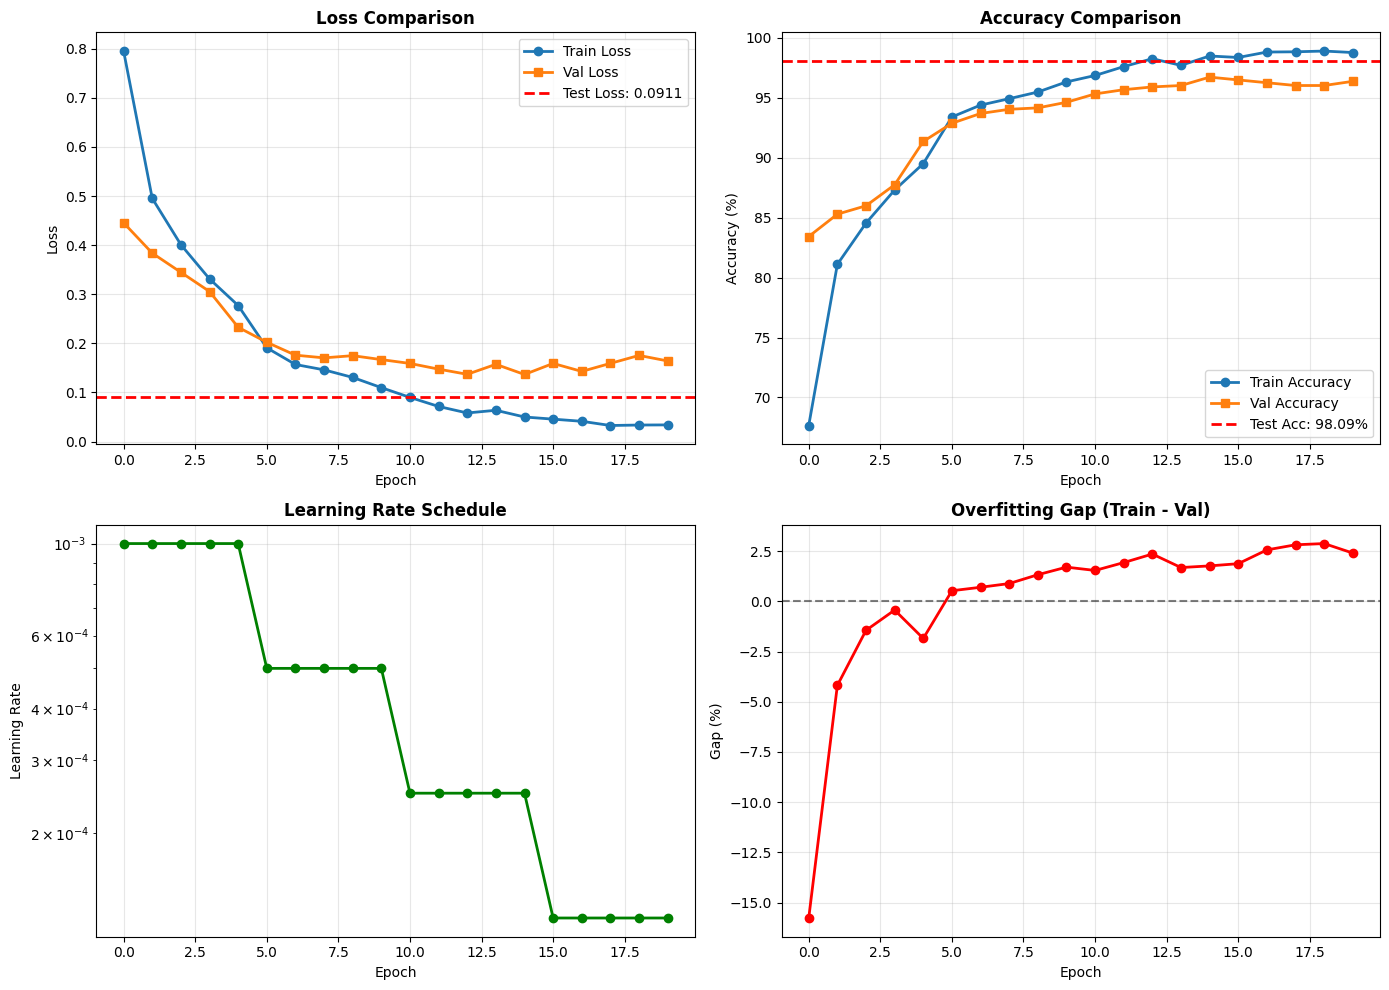


✓ Results saved to 'optimized_results.json'
✓ Plot saved as 'optimized_model_results.png'


In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss plot
axes[0, 0].plot(train_losses, label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(val_losses, label='Val Loss', marker='s', linewidth=2)
axes[0, 0].axhline(y=test_loss, color='red', linestyle='--', 
                   label=f'Test Loss: {test_loss:.4f}', linewidth=2)
axes[0, 0].set_title("Loss Comparison", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(train_accuracies, label='Train Accuracy', marker='o', linewidth=2)
axes[0, 1].plot(val_accuracies, label='Val Accuracy', marker='s', linewidth=2)
axes[0, 1].axhline(y=test_acc, color='red', linestyle='--', 
                   label=f'Test Acc: {test_acc:.2f}%', linewidth=2)
axes[0, 1].set_title("Accuracy Comparison", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy (%)")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate schedule
axes[1, 0].plot(learning_rates, marker='o', color='green', linewidth=2)
axes[1, 0].set_title("Learning Rate Schedule", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Learning Rate")
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Overfitting gap over epochs
gaps = [train_accuracies[i] - val_accuracies[i] for i in range(len(train_accuracies))]
axes[1, 1].plot(gaps, marker='o', color='red', linewidth=2)
axes[1, 1].set_title("Overfitting Gap (Train - Val)", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Gap (%)")
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/optimized_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results JSON
results = {
    'model_name': 'Version 4 - Optimized (Balanced Regularization)',
    'methodology': 'Proper train/val/test split - test evaluated once',
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'learning_rates': learning_rates,
    'best_val_acc': best_val_acc,
    'final_test_acc': test_acc,
    'test_loss': test_loss,
    'train_val_gap': train_accuracies[-1] - best_val_acc,
    'val_test_gap': best_val_acc - test_acc,
    'epochs': len(train_accuracies),
    'early_stopped': len(train_accuracies) < epochs
}

with open('/kaggle/working/optimized_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\n✓ Results saved to 'optimized_results.json'")
print("✓ Plot saved as 'optimized_model_results.png'")

#### ===========================
#### CONFUSION MATRIX
#### ===========================

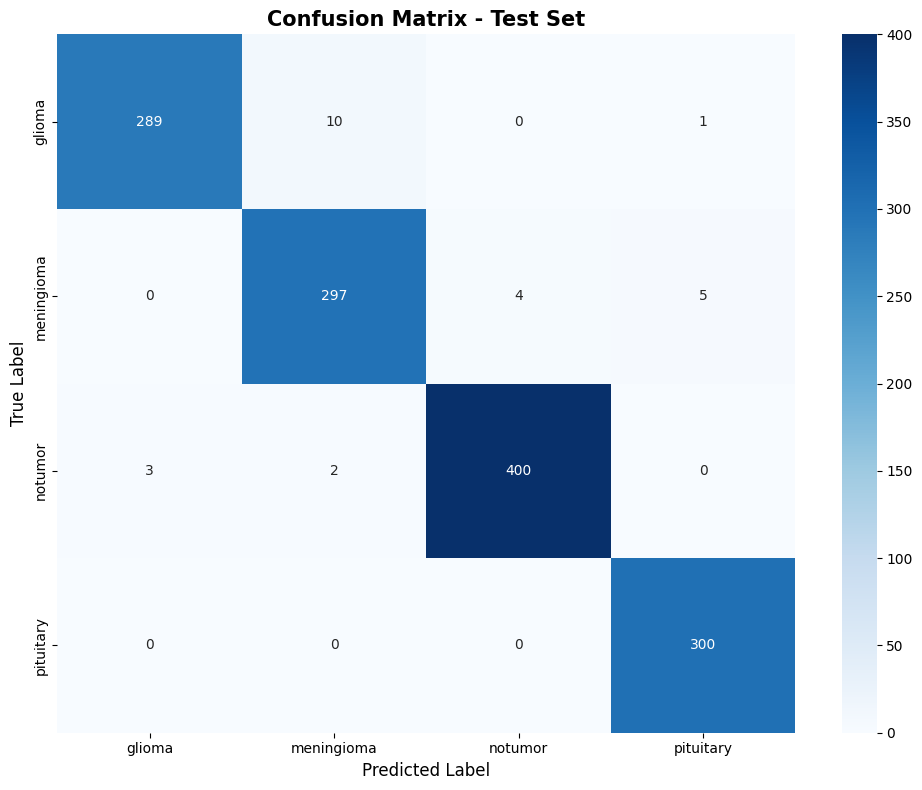

In [23]:
# Collect all predictions and true labels from the test set
y_true_list = []
y_pred_list = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true_list.extend(labels.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())

# Generate Confusion Matrix
cm = confusion_matrix(y_true_list, y_pred_list)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Test Set', fontsize=15, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

#### ===========================
#### CLASSIFICATION REPORT
#### ===========================

In [24]:
print("\nClassification Report:\n")
print(classification_report(y_true_list, y_pred_list, target_names=classes))

# Per-class Accuracy
print("\nPer-class Accuracy:")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, class_name in enumerate(classes):
    print(f"{class_name}: {cm_normalized[i, i]*100:.2f}%")


Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.96      0.98       300
  meningioma       0.96      0.97      0.97       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


Per-class Accuracy:
glioma: 96.33%
meningioma: 97.06%
notumor: 98.77%
pituitary: 100.00%


#### ===========================
#### VISUALIZING PREDICTIONS
#### ===========================

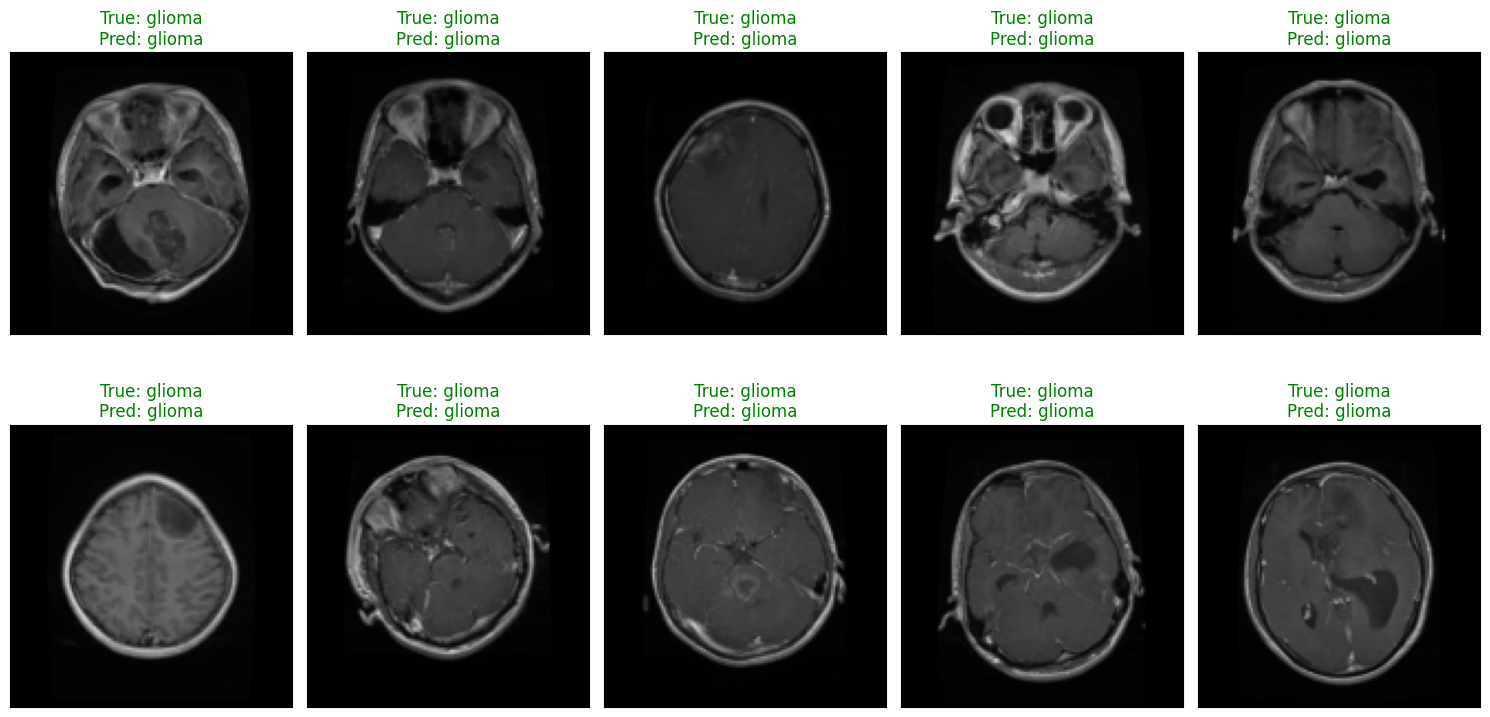

In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot
fig = plt.figure(figsize=(15, 8))
for idx in range(min(10, batch_size)): # Show up to 10 images
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    
    true_label = classes[labels[idx]]
    pred_label = classes[predicted[idx]]
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()

#### ===========================
#### Saving the model
#### ===========================

In [26]:
example_input = torch.randn(1, 3, 128, 128).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("/kaggle/working/brain_tumor_model_mobile.pt")